# Lab 2: Feature Engineering & Selection

In this lab, we work on feature engineering. Feature engineering is the process of determining which features to include in your model, explained further below. The question we will eventually have our model try and answer is:

*What drives the loan amount requested by KIVA borrowers? * 

In the language of Module 1, our outcome feature is **loan_amount**. In the next notebook, we will formalize this research question as a machine learning task. Our machine learning task will be to predict the loan amount that a borrower requests from KIVA using all the features we explore in this notebook.

**What is feature engineering?**

When we try to think of features that will predict loan_amount, we are doing feature engineering. We may not end up using all the features we create, but the process is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

Here's a look ahead at what we'll be doing in this notebook: 

1. Load data and packages 

2. Feature engineering and selection:
- borrower features
- loan features
- partner features

## **If you haven't already, please run through the notebooks from Module 1!**  You need the final ouput df.csv. You also need to pip install geopy in your terminal.

As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Module 1, we merged these data files and created new variables to form the data frame "df", we exported it as df.csv. We will use this dataframe now. 

In [337]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
from bs4 import BeautifulSoup
import re as re
import types
import seaborn as sns
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

import matplotlib.pyplot as plt
import time
plt.style.use('bmh') 

#package for location features
# If you do not already have this package, run pip install geopy from your terminal.
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [338]:
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [339]:
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 140)
pd.set_option('expand_frame_repr', True)

<b>Note</b>: Don't forget to change the name below to your own.

In [340]:
# Read in data
data_path = 'C://Users/JANE_DOE/Desktop/intro_course_data_science_for_good/data'
df = pd.read_csv(data_path+'df.csv', low_memory=False)

## Outcome Feature Engineering

In the exploratory module, we introduced the concept of outliers and showed why it might be important to remove outlier loan amounts. Outliers are not strictly defined, but here, we suggest that a reasonable definition of an outlier is an observation that falls outside 3 standard deviations from the mean. In laymans terms, this means that an outlier is on the very tail end of a distribution. For a more rigorous definition of a standard deviation, read more [here](http://mathworld.wolfram.com/Outlier.html).

Our data is very skewed by several extreme loan amount outliers. Now that we are considering a linear regression model, we should revisit removing our loan_amount outliers completely since these outlier amounts are infrequent yet will have an outsized influence, thus biasing our results.

First, we look at the distribution of loans with outliers included.

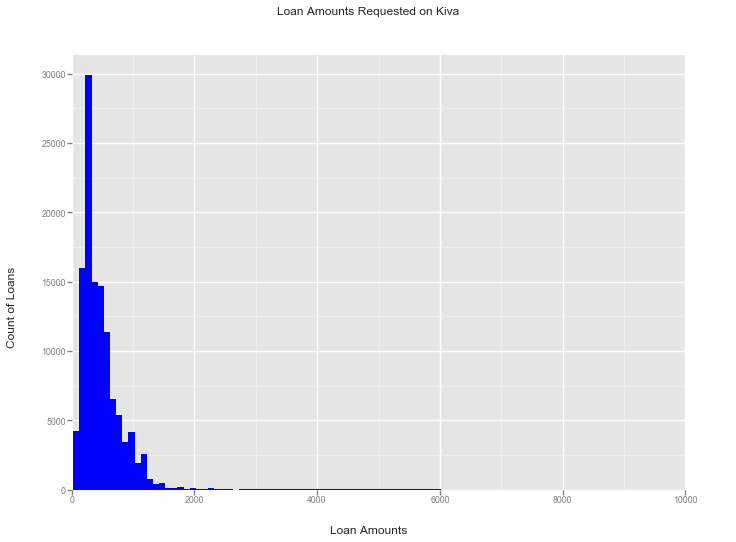

<ggplot: (-9223372036457426218)>

In [342]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 10000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We first analyze the implications of removing outliers by creating a new dataframe without outliers. We call this df_removed_outliers. We can immediately see that the data is less skewed. This suggests we should remove outliers from our df dataframe permanently.

In [343]:
# dataset without outliers
df_removed_outliers=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

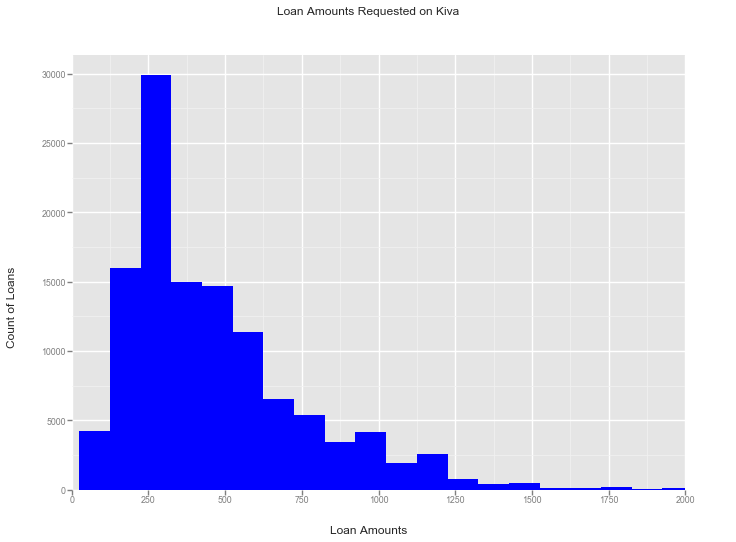

<ggplot: (370672304)>

In [344]:
ggplot(df_removed_outliers, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 2000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We should also examine what these outliers are to make sure they make sense excluding, and revisit our earlier standard of excluding those loans that fall outside 3 standard deviations. We can see from the sample below that many of the biggest loans are for education grants. However, since so many of our loans are for $250, we conclude that the outliers are not representative of the typical Kiva borrower. 

But how extreme are the outliers that we should exclude? Using the metric of standard deviation, it appears that many of the outliers as defined by those that lie outside 3 standard deviations are in fact for reasonable amounts. It is not clear we should simply exclude all of these loans.

In [345]:
outliers=df[~(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [346]:
outliers.head(2)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund,gender
57,57,57,Higher education costs,0.0,False,"[{'first_name': 'Stephen ', 'last_name': '', '...",NaN,['en'],"I am Stephen, the last born of a single mother...",NaN,NaN,NaN,650,NaN,1288706,2511865,1,0,0,18,15475,Kenya,KE,town,-1.283333 36.816667,point,Nairobi,Stephen,218.0,[],2017-06-07,2017-05-08,Education,fundraising,"[{'name': 'user_favorite'}, {'name': '#Schooli...",1596948.0,KES,2017-06-26T07:00:00Z,15475,"[{'due_date': '2022-07-01T07:00:00Z', 'amount'...",shared,0.1,lender,Irregularly,122,"[{'due_date': '2022-09-01T07:00:00Z', 'amount'...",['Higher Education'],NaN,NaN,to pay tuition fees at Strathmore University.,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.307016,1.978274,NaN,0.000000,NaN,976374.0,1.0,0.000000,77.0,Strathmore University,NaN,NaN,0.5,3.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2012-02-03T18:10:02Z,active,638400.0,http://www.strathmore.edu/,2017-05-08 10:00:03,NaN,2017-06-07 10:00:03,2017-06-26 07:00:00,1,2017-06-26,2017,5,NaN,Male
76,76,76,Cereals,0.0,False,"[{'first_name': 'Emmy', 'last_name': '', 'gend...",NaN,['en'],Emmy would be characterized by her neighbours ...,NaN,NaN,NaN,0,NaN,1290670,2514887,1,0,0,0,2825,Kenya,KE,town,1 38,point,Bomet,Emmy,156.0,[],2017-06-06,2017-05-07,Food,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",290000.0,KES,2017-04-29T07:00:00Z,2825,"[{'due_date': '2017-05-29T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,20,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,NaN,NaN,to buy cereals.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-07 21:10:03,NaN,2017-06-06 21:10:03,2017-04-29 07:00:00,1,2017-04-29,2017,5,NaN,Female


For now, let's be conservative. Instead of removing all observations that fall outside a standard deviation, let's simply restrict our analysis to loans below $6000. We can always come back and restrict it further using our outlier definition. We have commented out the code below, so we can come back and change what loans we exclude from our analysis.

In [347]:
# remove outliers from dataframe
#df=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [348]:
df=df[df['loan_amount']<=6000]

In [349]:
len(df)

118199

In [350]:
print(df.describe())

          Unnamed: 0   Unnamed: 0.1  basket_amount  \
count  118199.000000  118199.000000     942.000000   
mean    64434.689955   64399.551942       0.185775   
std     38187.891059   38166.408127       2.148199   
min         0.000000       0.000000       0.000000   
25%     29569.500000   29555.500000       0.000000   
50%     66543.000000   66501.000000       0.000000   
75%     98322.500000   98264.500000       0.000000   
max    127957.000000  127899.000000      25.000000   

       currency_exchange_loss_amount  funded_amount            id  \
count                   15675.000000  118199.000000  1.181990e+05   
mean                        6.792162     460.031811  7.095884e+05   
std                         9.857512     394.928783  3.413792e+05   
min                         0.010000       0.000000  2.510000e+02   
25%                         1.220000     250.000000  4.198620e+05   
50%                         3.490000     350.000000  6.976380e+05   
75%                         8.

In [351]:
df.to_csv(data_path+'df_module_2.csv')

## Explanatory Feature Engineering and Selection

Now that our outcome feature has been cleaned and examined, let's turn to our explanatory features. 

Too few features results in low predictive power, and too many features may mean we are adding features with little predictive power. We must also be careful not to violate the assumption that there is no multicollinearity present. Carefully choosing what features you think will be powerful enough to predict your outcome feature is difficult, and is subject to data availability and integrity problems. In short, it deserves your thoughtful consideration! 

### Let's start by asking, "What would motivate the loan amount a Kiva borrower would request?" 

Here are some hypotheses that came to the Delta teaching fellows:
- Your job.
- Where you live. What are local prices like? A loan in a high income urban area is likely to be higher on average than a loan in small rural town.
- The time of the year. Maybe you need to supplement your cash flow at certain points during the year
- Whether you have children, and your demographics (age, gender)
- Who is lending to you. Are they charging a high interest? High interest may make you hesitate to take out a big loan.
- The standards of the loan partner. If they have lax standards, and are offering you a big loan with little collatoral needed, you may be tempted to accept a higher amount. 
- Whether you have taken a loan before. Did you have a good experience borrowing on KIVA?

While this is what we decided to start with, there could be many more features you can think of. In fact, the beauty of feature engineering is that diverse perspectives often bring out powerful new discoveries in the data. 

There is also the power of subject matter expertise, where you may have an innate understanding of what patterns to look at in the data because of familiarity with microfinance or your understanding of Kenyan culture. This is a powerful advantage in machine learning because it allows you to see patterns that someone without the same perspective might miss. 

Let's turn first to demographic features.

## 1: Demographic features

## Gender

Recall that we created the gender feature in our initial exploratory analysis. We know that there appears to be a relationship between gender and loan_amount requested. On average, women appear to request lower loan amounts than men.

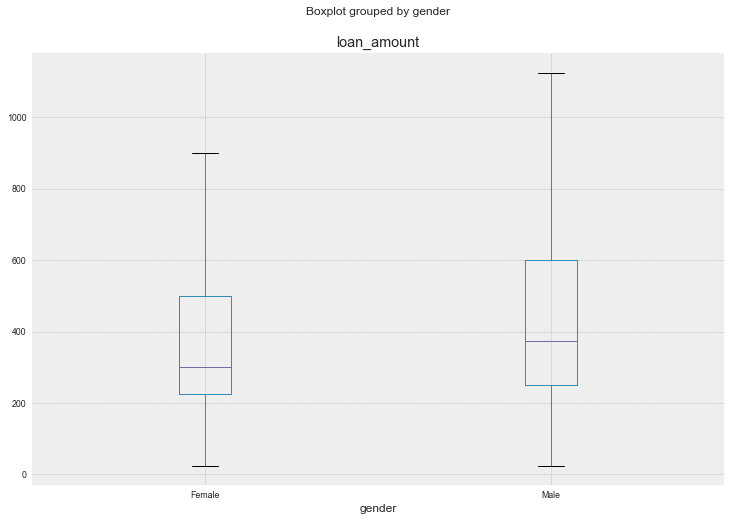

In [352]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='gender', showfliers=False, figsize=(12,8))

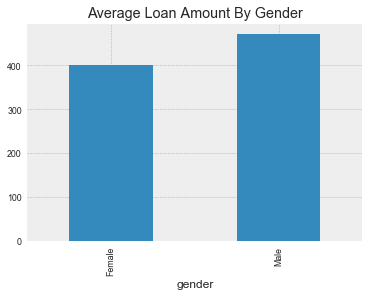

In [353]:
df[df['borrower_count'] == 1].groupby('gender')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender");

For group loans, we will also want to understand how the % composition of each group drives the performance of the model.

In [536]:
df['num_male'] = df['borrowers'].apply(lambda x: x.count('''M'''))

In [538]:
df['num_female'] = df['borrowers'].apply(lambda x: x.count('''F'''))

In [544]:
df['pct_female']=100.00*df['num_female']/(df['num_male']+df['num_female'])

## Status and Age

In the first module, we only considered gender as a demographic feature. However, there could be other demographic features that influence the loan amount you request. 


Let's start with a broad exploration of of the description field. This will help showcase how to manipulate string data, and will also allow us to extract some interesting age and status related features.

In the cell below we use Numpy's  [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function  and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to create the widowed", "kids", and "elderly" features. 

We are using Numpy's filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest - in this case, any variation of the words widow, and any indication of children. Note that we try to be inclusive by testing for variations like "daughter" and "son."

In [354]:
## Whether or not the borrower is widowed
#  Note the str.contains function

df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=0)==True, 1, 0)

## Whether or not the borrower has children, notice we look for many variants of the word.
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter|mother|father|parents", na=0) ==True,1,0)
## Whether or not the borrower is elderly
df['elderly'] = np.where(df['tags'].str.contains("#Elderly", na=0) ==True, 1, 0)


We create the features above because we had the hypothesis that certain demographic features may drive the loan amount requested. However, all these new features face a data scarcity problem. We can see this by looking at the value_counts() of each new feature. 

In [355]:
df['widowed'].value_counts()
df['kids'].value_counts()
df['elderly'].value_counts()

0    115621
1      2578
Name: widowed, dtype: int64

1    101202
0     16997
Name: kids, dtype: int64

0    112723
1      5476
Name: elderly, dtype: int64

The words are only contained in a handful of descriptions. Features with little variance so it will quickly drop out in any model we try it in. However, kids seems promising.

**Data scarcity** reduces the utility of the new field as an explanatory feature because if most observations of the feature are missing, it will not be a good discriminator in predicting loans, because almost everyone will have a null value for that explanatory feature. It does not provide much new information. Consider this analogy: if we are trying to predict nationality using accent. There are 20 nationalities present, but everyone has the same accent - it does not provide much new information. Accent will not be useful anymore in getting us closer to separating nationalities; we should instead rely on other features. 

Despite the weakness of these features, this has still been a useful process. Many steps in feature development involve creating features that will not ultimately be used. It is through creative exploration that we will eventually pinpoint our winning features. In fact, this has given us the idea to more systematically extract age.

Below, we do one final validation step and plot the features we just extracted. You can see in the boxplots below that both elderly and widowed fo not differ much in the distribution of loan amount. That is another strong hint not to include them as features in our final model. Any good explanatory variable will cause variance in the explanatory variable.

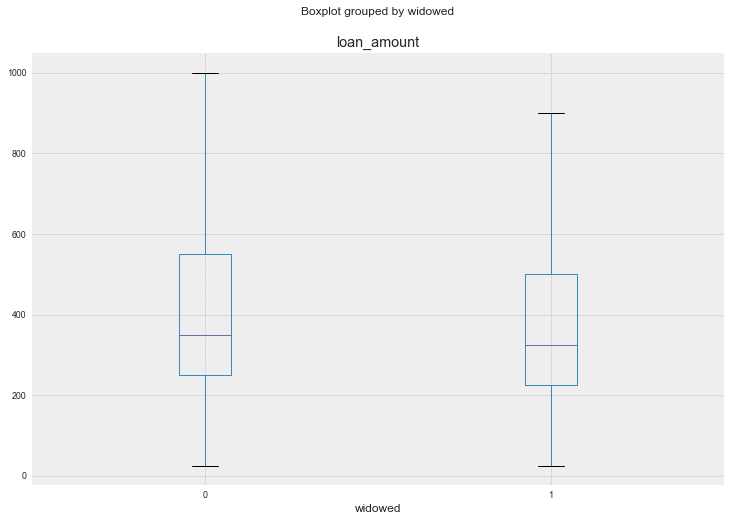

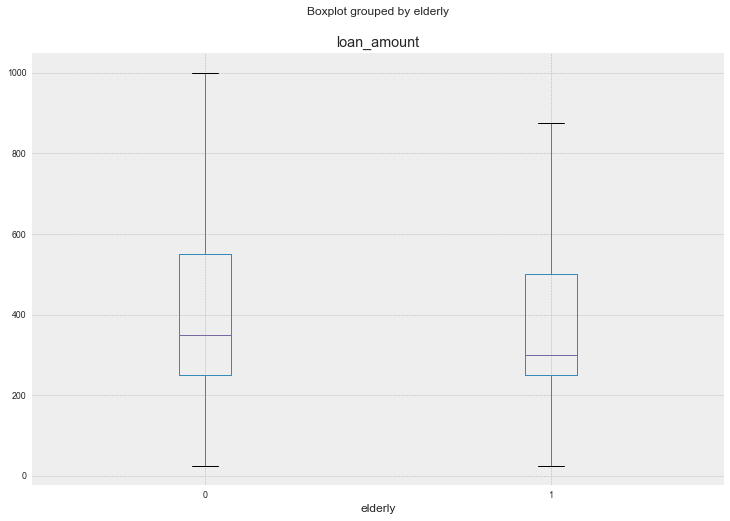

In [356]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='widowed', showfliers=False, figsize=(12,8));

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='elderly', showfliers=False, figsize=(12,8));

However, it is worth taking a closer look at kids. This field still faces a data scarcity issue, but we can see that lenders with kids do have a more narrow distribution than lenders without. It appears that parents are less likely to take high value loans.

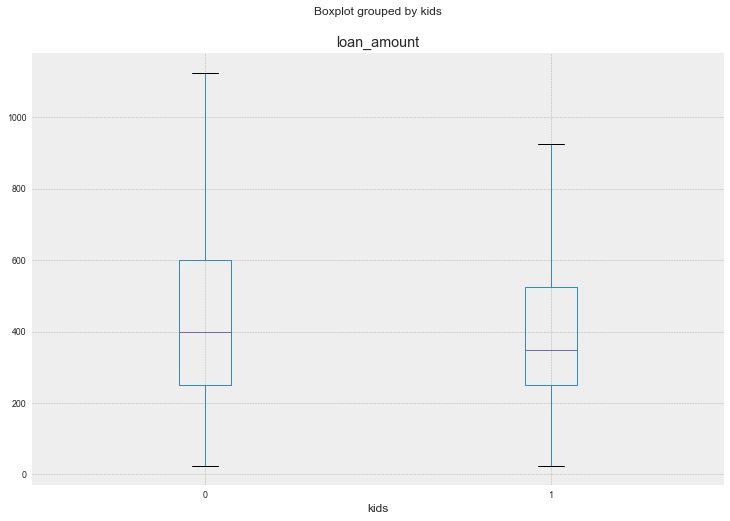

In [357]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='kids', showfliers=False, figsize=(12,8));

## Tags

In the dataset we have a really interesting field called tags. You can take a look at the field below. Let's create a feature called number of tags.

In [358]:
df['tags'].head(2)

0    [{'name': '#Woman Owned Biz'}, {'name': '#Pare...
1                                                   []
Name: tags, dtype: object

In [359]:
df['num_tags'] = df['tags'].apply(lambda x: x.count(','))

In [360]:
df['num_tags'].value_counts()

0     73716
2     13059
1     11285
3      8877
4      5414
5      2524
6      1813
7      1123
8       332
9        45
10       10
11        1
Name: num_tags, dtype: int64

Let's plot the data to get a feel for the relationship.

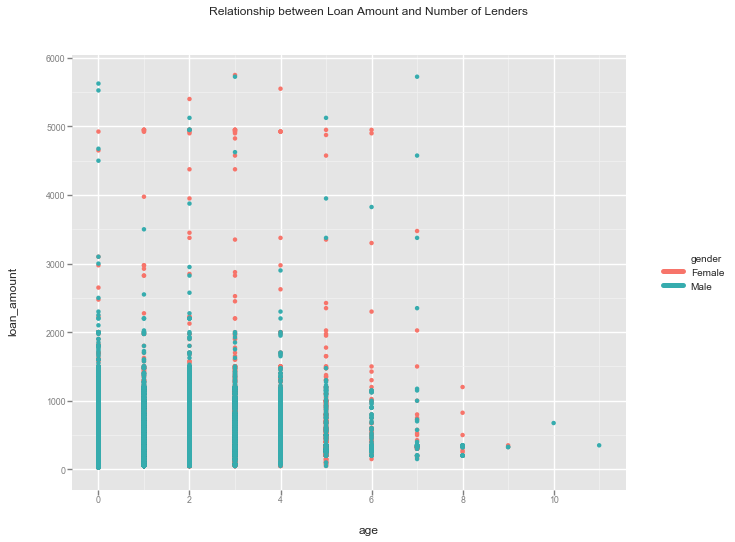

<ggplot: (-9223372036542085372)>

In [361]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'num_tags', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Lenders") + xlab("age") + ylab("loan_amount")

We can see there is a data scarcity issue in the number of loans with more than 8 tags. We may want to consider bucketing this before we use it as a feature. Now, let's take a closer look and extract the tags as features.

In [362]:
df['tags'].value_counts().index[:10]

Index(['[]', '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}]',
       '[{'name': 'user_favorite'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}, {'name': '#Repeat Borrower'}]',
       '[{'name': '#Parent'}]', '[{'name': '#Woman Owned Biz'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}, {'name': '#Schooling'}]',
       '[{'name': '#Parent'}, {'name': '#Repeat Borrower'}]',
       '[{'name': 'volunteer_pick'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Vegan'}, {'name': '#Parent'}]'],
      dtype='object')

Lets create individual features for tags that we think may be interesting and hot code the reponse. This means that value of that features = 1 if the tag was present and 0 if the tag was not present.

In [363]:
tag_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "#Schooling", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
for tag in tag_vals:
    if tag not in df.columns:
        df['tag_'+str(tag)]=df['tags'].apply(lambda x: 1 if tag in x else 0) 

In [364]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund,gender,widowed,kids,elderly,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology
0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,NaN,2017-06-08 00:40:03,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN,Female,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,NaN,2017-06-08 00:30:05,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN,Male,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [365]:
df['tag_#Woman Owned Biz'].value_counts()
df['tag_#Parent'].value_counts()
df['tag_#Repeat Borrower'].value_counts()
df['tag_#Schooling'].value_counts()
df['tag_#Parent'].value_counts()
df['tag_volunteer_pick'].value_counts()
df['tag_#Vegan'].value_counts()
df['tag_volunteer_like'].value_counts()
df['tag_#Animals'].value_counts()
df['tag_#Eco-friendly'].value_counts()
df['tag_#Technology'].value_counts()

0    95950
1    22249
Name: tag_#Woman Owned Biz, dtype: int64

0    83624
1    34575
Name: tag_#Parent, dtype: int64

0    104963
1     13236
Name: tag_#Repeat Borrower, dtype: int64

0    106814
1     11385
Name: tag_#Schooling, dtype: int64

0    83624
1    34575
Name: tag_#Parent, dtype: int64

0    115321
1      2878
Name: tag_volunteer_pick, dtype: int64

0    107367
1     10832
Name: tag_#Vegan, dtype: int64

0    116259
1      1940
Name: tag_volunteer_like, dtype: int64

0    111271
1      6928
Name: tag_#Animals, dtype: int64

0    108511
1      9688
Name: tag_#Eco-friendly, dtype: int64

0    110792
1      7407
Name: tag_#Technology, dtype: int64

We can immediately see that some tags are more useful then others because of coverage. The #parent tag, # repeat borrower tag, #women owned biz tag, #schooling tag all look really useful because they have more than 10,000 observations. 

Before we take a deep dive into the features one of things we should check for is whether Kiva has been tagging loans all along, or whether this is a feature introduced later in their history. We can see from the chart below that in fact this feature only gained momentum in 2015.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

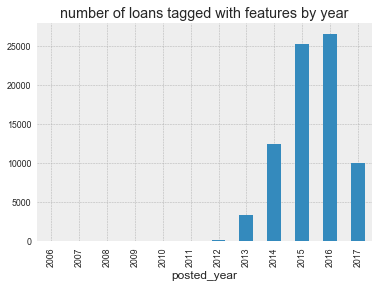

In [366]:
df[(df['borrower_count'] == 1)].groupby('posted_year')['num_tags'].sum().plot(kind="bar", title='number of loans tagged with features by year')
plt.xticks(rotation=90)

### Women Owned Business

We can see from the box plot that women owned businesses actually request higher amounts on average. However, the boxplot tells a more complete story, we can tell that while the average is higher the range is more narrow.

In [367]:
df['tag_#Woman Owned Biz'].value_counts()

0    95950
1    22249
Name: tag_#Woman Owned Biz, dtype: int64

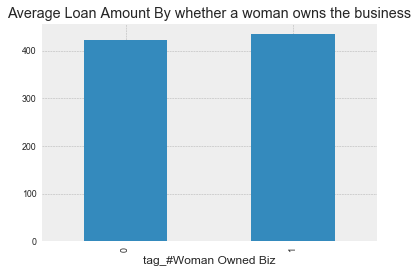

In [368]:
df[df['borrower_count'] == 1].groupby('tag_#Woman Owned Biz')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By whether a woman owns the business")

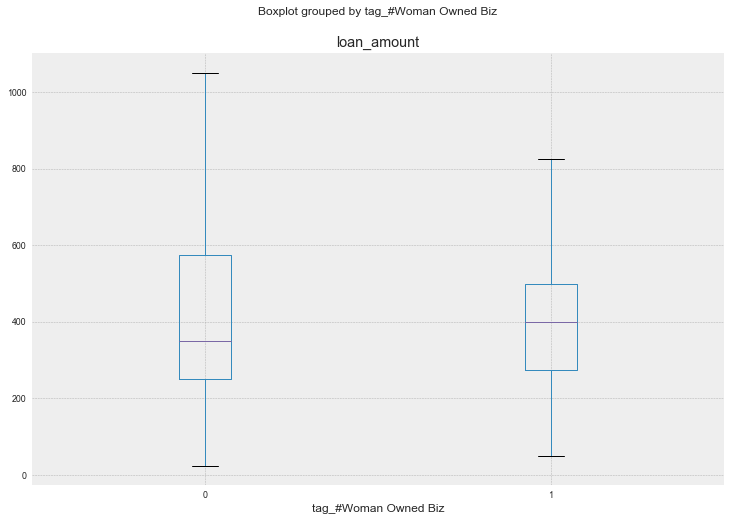

In [369]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='tag_#Woman Owned Biz', showfliers=False, figsize=(12,8))

## Parent

Below, the tag tells us that parents request a higher amount then those that do not have children. This seems to be the opposite of what we learnt when we looked at our handcrafted kids feature based upon our string match.


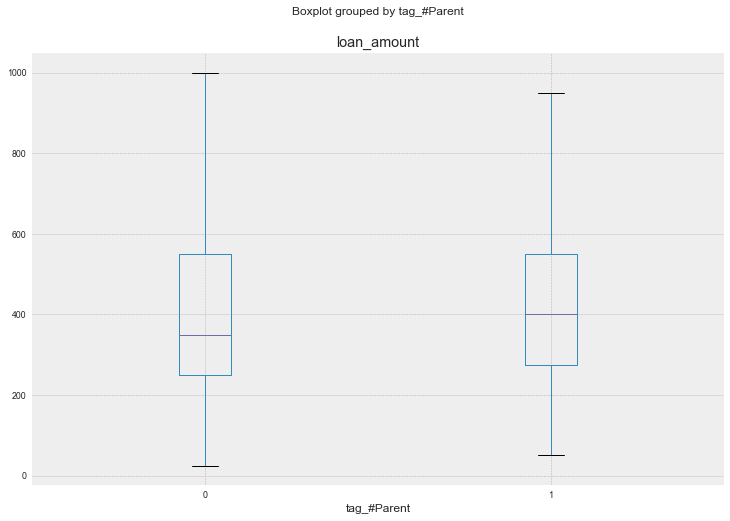

In [370]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='tag_#Parent', showfliers=False, figsize=(12,8))

We can see from our value_counts() below that our handcrafted 'kids' feature has much higher coverage in the dataset. Let us try and combine the features because there appear to be many loans that were not tagged parent that we caught using our text match.

In [371]:
## Whether or not the borrower has children, notice we look for many variants of the word.
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter|mother|father|parents", na=0) ==True,1,0)

df['kids'].value_counts()
df['tag_#Parent'].value_counts()

1    101202
0     16997
Name: kids, dtype: int64

0    83624
1    34575
Name: tag_#Parent, dtype: int64

In [372]:
df['parent'] = np.where(df['tag_#Parent']==1, df['tag_#Parent'], df['kids'])

In [373]:
df['parent'].value_counts()

1    102014
0     16185
Name: parent, dtype: int64

Now, let's plot the average. Below, with better coverage we seem to be telling a very different story. The average amount and distribution of loan amounts requested by parents appears to be lower.

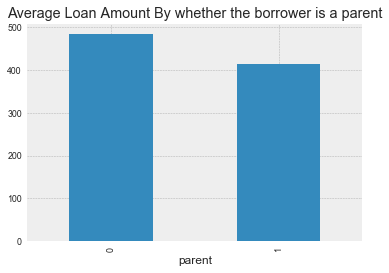

In [374]:
df[df['borrower_count'] == 1].groupby('parent')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By whether the borrower is a parent")

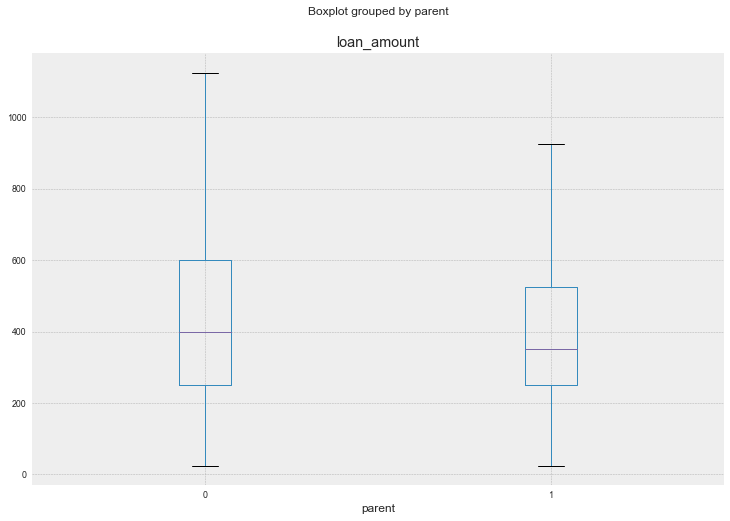

In [375]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='parent', showfliers=False, figsize=(12,8))

## Repeat Borrower

Now let's look at repeat borrowers. There are ~13,000 repeat borrowers in our dataset. A strong hypothesis could be that if you are a returning borrower you may request more since you have already demonstrated ability to pay back.

In [376]:
df['tag_#Repeat Borrower'].value_counts()

0    104963
1     13236
Name: tag_#Repeat Borrower, dtype: int64

In [377]:
df['tag_#Repeat Borrower'].value_counts()

0    104963
1     13236
Name: tag_#Repeat Borrower, dtype: int64

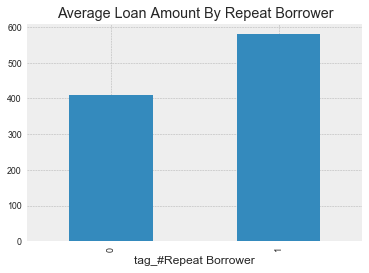

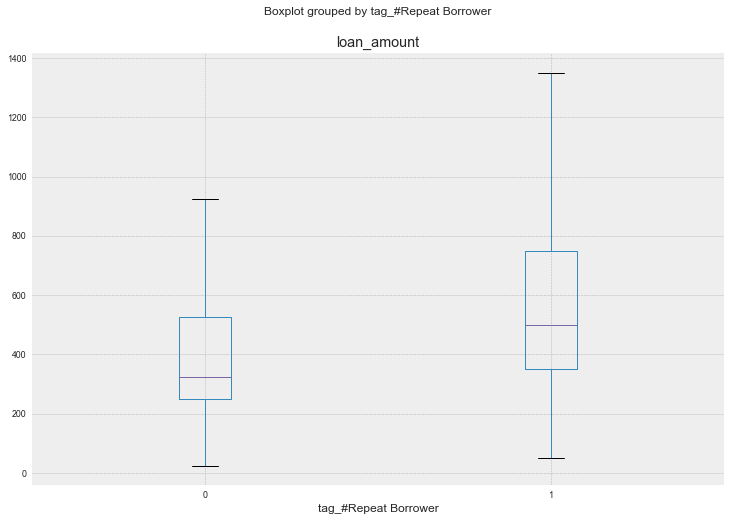

In [378]:
df[df['borrower_count'] == 1].groupby('tag_#Repeat Borrower')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Repeat Borrower")

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='tag_#Repeat Borrower', showfliers=False, figsize=(12,8))

There certainly seems to be a strong relationship here! We should definately include this feature.

## Schooling

In [379]:
df['tag_#Schooling'].value_counts()

0    106814
1     11385
Name: tag_#Schooling, dtype: int64

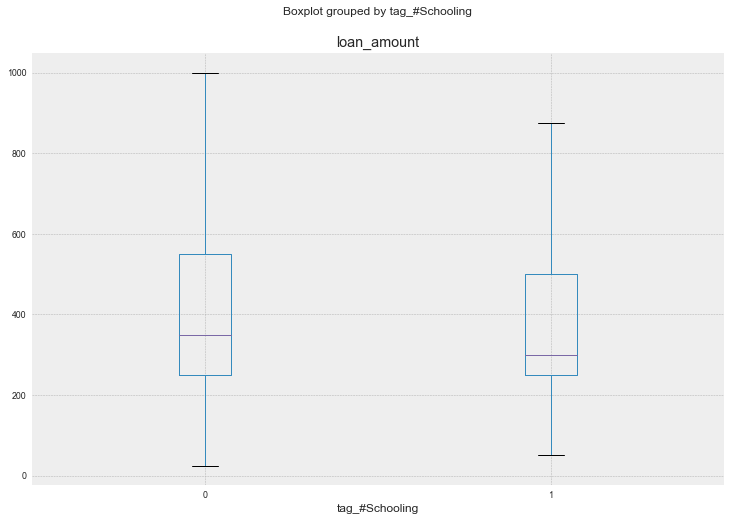

In [380]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='tag_#Schooling', showfliers=False, figsize=(12,8))

## Marital Status

Before we move on, we read through a few descriptions and realize many loans mention whether the applicant is married. We decide to take a look at this feature by doing a text search for the word married, husband or wife.

In [381]:
## Whether or not the borrower is married
df['married'] = np.where(df['description.texts.en'].str.contains("married|husband|wife", na=0)==True, 1, 0)

Suprisingly, the difference in average amount is not that impressive between married and unmarried borrowers. Let's take a look at the boxplots to get a better sense of what is going on.

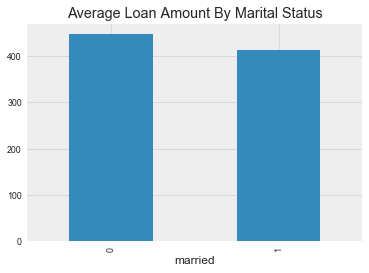

In [382]:
df[df['borrower_count'] == 1].groupby('married')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Marital Status")

The boxplots we see a richer story about the difference in distribution. Married borrowers have a narrower range.

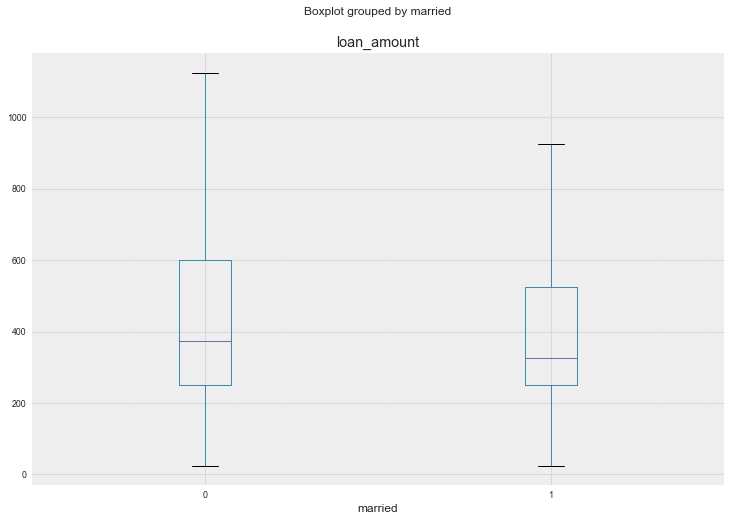

In [383]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='married', showfliers=False, figsize=(12,8))

We were right to take a look at it! Married has good coverage and it seems that lenders who are married typically request smaller loans. This suggests lenders who are married are willing to tolerate less risk. 

In the last class we discussed reasons that a woman might be requesting a lower loan amount. One of the hypotheses that came up was that a woman might need to ask permission from her husband to request a loan if she is married. Now we have a feature for whether someone is married we can put this to the test! 

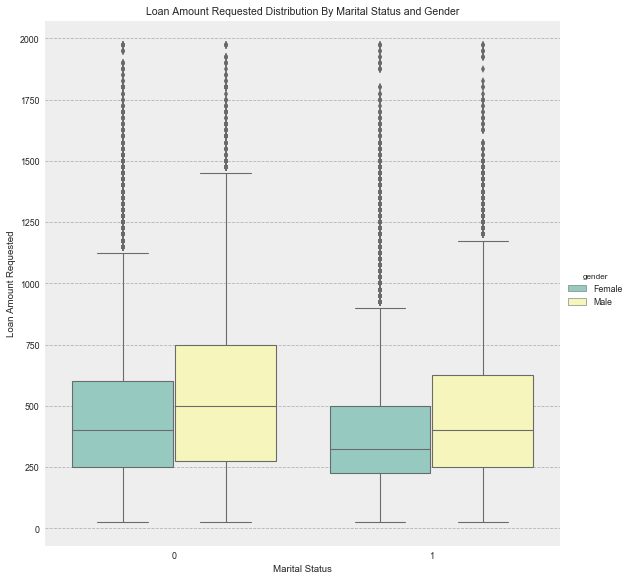

In [384]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

sns.factorplot(x="married", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)
plt.title('Loan Amount Requested Distribution By Marital Status and Gender')
plt.xlabel('Marital Status')
plt.ylabel('Loan Amount Requested')

In fact we can see from the boxplot above that both married men and women tend to request lower amounts. Women consistently appear to request lowers amounts in both the married and unmarried groupings. This reduces the strength of that hypothesis as one of the key reasons women request lower amounts.

The marriage field has turned out to be very interesting and we will definately include it in our model!


#### A note of caution!

While we are pleased with the results above, let's be aware that free form text is always going to be a problematic feature. For example, there may be inconsistencies in what people choose to disclose about themselves. We can fairly sure that when a person says they are married thay are in fact married, but if they don't it may just be by omission. In other words, they may be married but choose not to report it on their loan application (there is no requirement they do so!).

The lack of a consistent way data is reported is a problem you will face again and again in data science. Often, when we find compelling results like the boxplot above it is a strong signal we should push for more systematic collection of those fields. This could take the form of a questions asking about marital status that can already be responded to with 'single', 'married', 'divorced'.

## Age and number of children

Our work with string matching has given us the idea to extract age and also number of children in a more systematic way. In the cells below, we parse out the **age** of the user by doing the following:

1. Importing a CSV mapping of age strings that appear in the Kiva description field (e.g. "2 years") to the integer counterparts (e.g. 2). 
2. We then define a function to check for each of these string values within the `description.texts.en` field of our main dataframe. If a match is found, we append that string value to a new list, "age", which we create at the start of the function. If no match is found, we append a blank string. When the function has completed, we have a list the same length of our main dataframe, with the corresponding age string value for each observation (e.g. "2 years" or " " if there is no age value available)
    1. We use functions from the [regular expression package](https://docs.python.org/2/library/re.html) to perform the string searches within the `description.texts.en`. Specifically, we use `re.compile` and  `re.findall` functions to first compile all possible age strings of interest, and then find all instances of the corresponding string.
3. We then create a new column in our main dataframe, "age", which is simply the list we created in step 2.
4. Finally, we perform a left join of our main dataframe with the CSV mapping, to map the string versions of age with their integer counterparts.



In [385]:
lookup_tags = pd.read_csv(data_path+'tags.csv')

In [386]:
lookup_tags.head(2)

,age,age_int,children_1,children_2,children_int
0,1 years,1,one child,1 child,1.0
1,2 years,2,two children,2 children,2.0


In [387]:
## Age of borrower and number of children

# define a function that performs a loop that parses out all words, 
#  finds age and number of children match and creates a list that is return at the end of the function

def text_search(tag):
    #creates empty lists that are then added to in loop
    number=[]
    flag = tag.astype(str)
    match=flag.tolist()
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['description.texts.en']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        number.append(word_1)
                    else:
                        number.append('')
        except:
            print('error')
            
    return(number)

In the cell below we write a small loop to go through each feature and search. Running this loop is fairly computationally expensive since it is doing a string match against every row of the data. You can expect it to take a few minutes to run. You can add other lists to the tags csv to extend the features you search for.

In [388]:
features=['age','children_1', 'children_2'] 

for feature in features:
        number= text_search(lookup_tags[feature])
        df[feature]=pd.DataFrame(number)

As always we take a look at our dataframe and check the length of the index to make sure our loop was successful. Then we join in the int fields in our imported tags so we can treat these fields as a numerical variable (you will see we have successfully created age_int and children_int).

In [389]:
df.head(2)
len(df.index)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund,gender,widowed,kids,elderly,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,parent,married,age,children_1,children_2
0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,NaN,2017-06-08 00:40:03,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN,Female,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,44 years,,6 children
1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,NaN,2017-06-08 00:30:05,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN,Male,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,42 years,two children,


118199

Finally, we map the integer fields unto our dataframe. That way we can decide whether to use number of children as a str feature or an int feature.

In [390]:
mydict = dict(zip(lookup_tags.children_1, lookup_tags.children_int))
df['children_int_1'] = df['children_1'].map(mydict)

mydict = dict(zip(lookup_tags.children_2, lookup_tags.children_int))
df['children_int_2'] = df['children_2'].map(mydict)

mydict = dict(zip(lookup_tags.age, lookup_tags.age_int))
df['age_int'] = df['age'].map(mydict)

In [391]:
df['children_int'] = df['children_int_1'].fillna(df['children_int_2'])
df['children_int']=df['children_int'].fillna(0)

In [392]:
df.to_csv(data_path+'df_module_2.csv')

## Number of children

Now that all of our data processing is over, let's take a look at the number of children against loan amount. Very interesting! We see what appears to be a negative relationship, lenders with more children tend to request lower loan amounts.

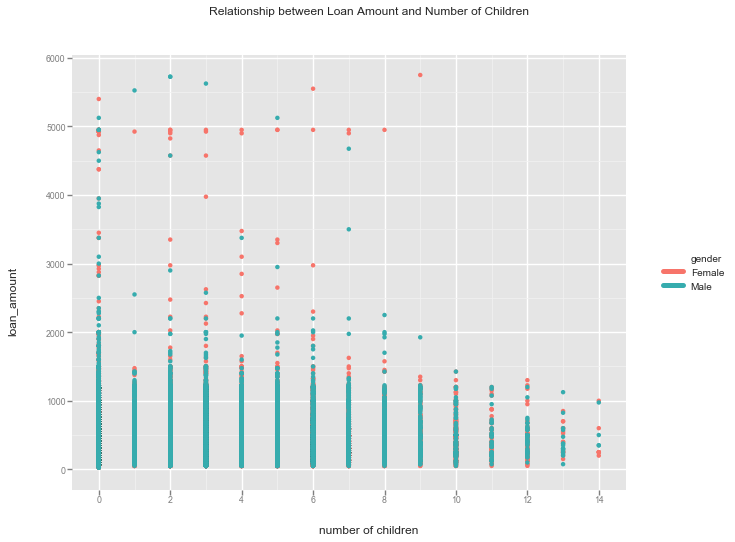

<ggplot: (-9223372036483592318)>

In [393]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'children_int', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Children") + xlab("number of children") + ylab("loan_amount")

Surprisingly, in the chart above it appears that women may be requesting more than men. This is really surprising, since all our analysis of gender so far has communicated that women on average request less. Let's see what is going on by returning to our binary childrens boxplot from earlier.

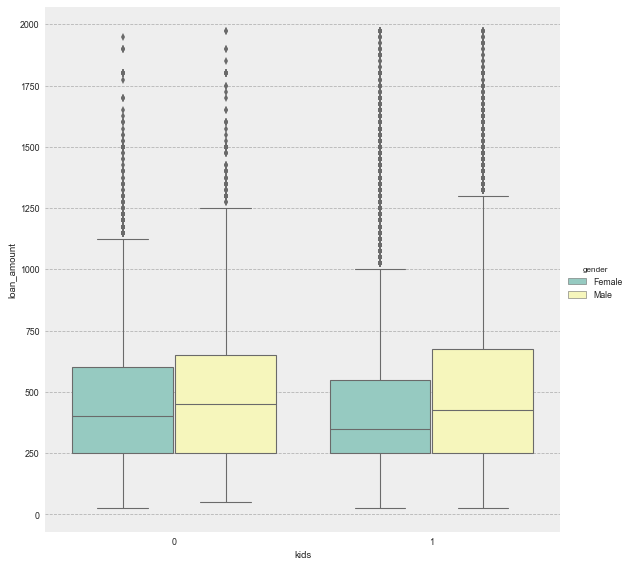

In [394]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="kids", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

It turns out this is not the case, men with children are still requesting more than women with children. This is why using a tool like boxplots is so important. It is a powerful way to quantify the distribution we percieve.

Let's also plot is using our more granular number of children data. This again reinforces that women are systematically asking for less than men.

We can also note that although we perceived a negative relationship between number of children and loan amount requested in our initial scatter plot, it appears that at least the median loan amount requested goes up as the number of children go up. 

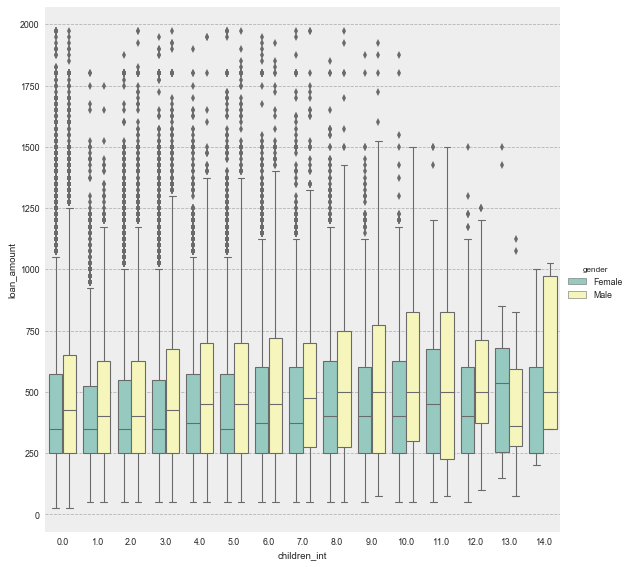

In [395]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="children_int", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

The number of children feature is very promising, we will definately be including it in our model!

## Age

Now let's turn to age. Below, we plot age against loan amount to get a sense of the strength of the relationship.

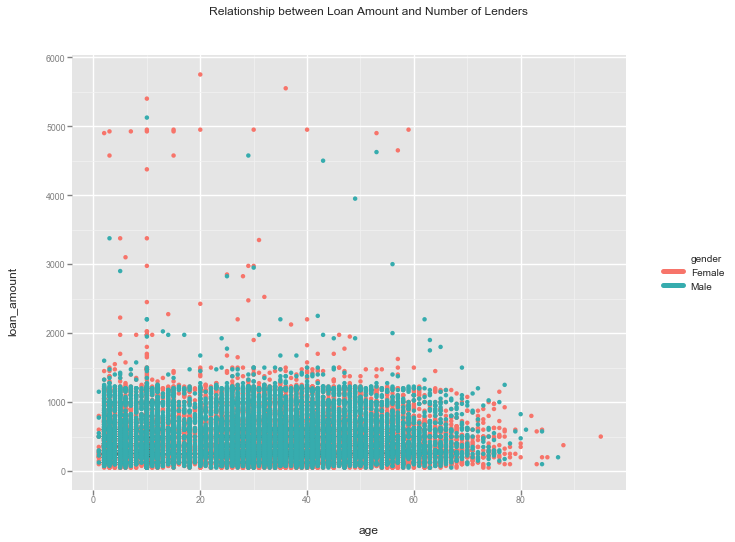

<ggplot: (-9223372036334959998)>

In [396]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'age_int', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Lenders") + xlab("age") + ylab("loan_amount")

From the chart above, we can see that while we have learnt something about the age distribution it is unfortunately not particularly powerful at predicting loan amount. We decide to try one more thing and bucket age to see if it strengthens the relationship.

In [397]:
mybins =range(0, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
df['age_bucket'].value_counts()

(30, 40]    12412
(0, 10]     12318
(20, 30]     9518
(40, 50]     8481
(10, 20]     6256
(50, 60]     4756
(60, 70]     1583
(70, 80]      233
Name: age_bucket, dtype: int64

Strange -- looks like there are a lot of 10 year olds borrowers! This doesn't make sense, so let's take a look at the data where age_int < 10 to investigate. 

In [398]:
df[df['age_int']< 2]['description.texts.en'][0:1]

1708    Ellinar is a married woman with three children...
Name: description.texts.en, dtype: object

The data tells us that many people are not reporting their own age, but in fact are telling us about their young children. This reveals a big data integrity problem - the feature age_int is not what we thought it was. This raises the question of how many people reported their own age in the first place. 

One way to address this is to conservatively only look at observations where the age is more than 20. We do this below by starting at bins at 20.

In [399]:
mybins =range(20, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
##df['age_bucket'].value_counts()

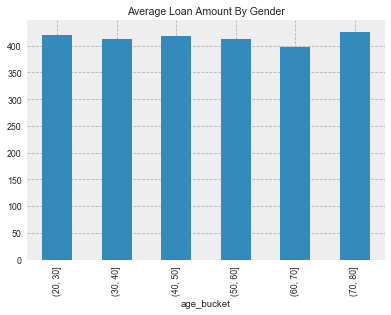

In [400]:
df[df['borrower_count'] == 1].groupby('age_bucket')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender")

Unfortunately, it did not improve the relationship. While 70-80 year olds appear to be requesting larger loans on avg it is very similar amounts for all other ages. But don't despair!

Again, meeting dead ends in feature engineering is a perfectly normal part of developing a model. We included all these weaker feature explorations so you can understand that even experienced data scientists try a lot of things that are not successful. 

The best way to build a successful model is to iterate quickly and not get stuck when a feature doesn't work out.

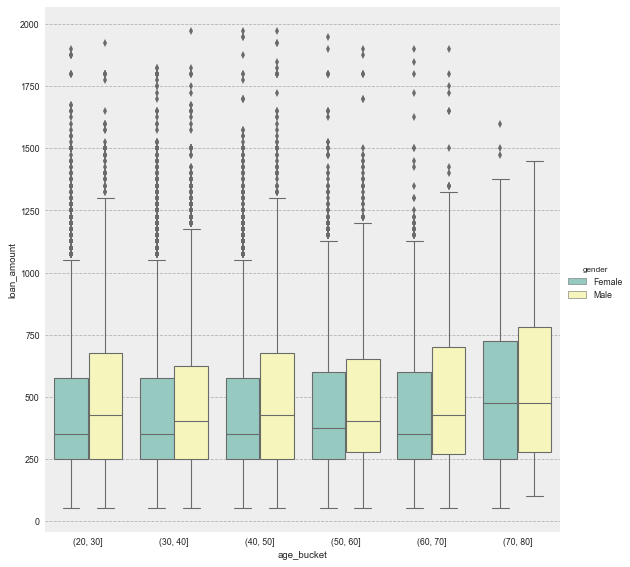

In [401]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="age_bucket", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

The last thing we do is fill in empty age with the mean.

In [402]:
df['age_int']=df['age_int'].fillna(df['age_int'].mean())

## Location

### NOTE: This is a fairly computationally expensive piece of code. You may have to re-run the location match because the API sometimes break. Please save your dataframe as soon as it is done so you do not have to run it again.

Location is probably very predictive of loan amount because intuitively there are differences in the cost of living and the type of sector between different regions. The cost of living in London, UK is very different from the cost of living in Mombasa, Kenya for example. You can also imagine that within Kenya there are likely differences in the cost of living between provinces or even counties. 

Location is a feature we want to include! However, our current location data is really messy. There is an issue with of geo-coordinates field where most coordinates are from a single location. Instead, we have to rely on location.town but this appears to be entered by hand and there are many spelling mistakes, variations of the same entry and incomplete addresses that prevent us from aggregating this data in a useful way. In order to use location, we somehow need to pull the province or county associated with each town. To do this we turn to the Google Geocode API. You can read more about this api [here](http://geopy.readthedocs.io/en/1.10.0/).

The api is very sensitive to how clean (standardized) the input is. Because our location field appears to be a non standardized field (it is the result of data written by hand), we have a lot of cleaning to do before we can call the api. However, even after this cleaning the api call tends to break frequently so we set up a [recursive function](https://www.programiz.com/python-programming/recursion), which means if there is an exception because of the quality of text or because the internet connection is weak, it calls the api again within the loop.

In [403]:
df['location']=df['location.town'].astype(str).map(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r'',x).lower().rstrip().lstrip())
df['location']=df['location'].map(lambda x: re.sub(r'kenya', r'', x))
df['location']=df['location'].map(lambda x: re.sub(r' +', r' ', x))

df['location']=df['location'] + ' ' + 'kenya'

unique_location = df['location'].unique()
unique_location.sort()
len(unique_location)

1204

In [404]:
lookup={}
geolocator = Nominatim()

def location_match(unique_location, lookup):
    #creates empty dictionary
    y=0
    print(len(unique_location))
    for x in unique_location:
        if x in lookup.keys():
            print ('already added, pct complete %d' % (100.00*y/len(unique_location)))
        else:
            print ('adding %s, %d out of %d, pct complete %d' % (x, y, len(unique_location), 100.00*y/len(unique_location)))
            try:
                lookup[x]=geolocator.geocode(x, timeout=10)
            except GeocoderTimedOut:
                return location_match(unique_location, lookup)
                return lookup
        y=y+1
            
    return lookup

In [406]:
location = location_match(unique_location, lookup)

1204
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
alrea

In [518]:
df['location_detail'] = df['location'].map(location)
df['location_str']=df['location_detail'].astype(str).map(lambda x: re.sub(r'Kenya',r'',x).lower().rstrip().lstrip())

In [519]:
lookup_tags=pd.read_csv(data_path+'/province_counties_KE.csv')

In [520]:
lookup_tags.head(2)

,county,province,capital
0,mombasa,coast,mombasa
1,kwale,coast,kwale


In [521]:
lookup_tags['county'].unique()

array(['mombasa', 'kwale', 'kilifi', 'tana river', 'lamu', 'taita',
       'garissa', 'wajir', 'mandera', 'marsabit', 'isiolo', 'meru',
       'tharaka', 'embu', 'kitui', 'machakos', 'makueni', 'nyandarua',
       'nyeri', 'kirinyaga', 'muranga', 'kiambu', 'turkana', 'pokot',
       'samburu', 'trans nzoia', 'uasin', 'elgeyo', 'nandi', 'baringo',
       'laikipia', 'nakuru', 'narok', 'kajiado', 'kericho', 'bomet',
       'kakamega', 'vihiga', 'bungoma', 'busia', 'siaya', 'kisumu', 'homa',
       'migori', 'kisii', 'nyamira', 'nairobi'], dtype=object)

In [522]:
# define a function that performs a loop that parses out all words, 
#  finds age and number of children match and creates a list that is return at the end of the function

def text_search(tag):
    #creates empty lists that are then added to in loop
    number=[]
    flag = tag.astype(str)
    match=flag.tolist()
    print(match)
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['location_str']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        number.append(word_1)
                    else:
                        number.append('')
        except:
            print('error')
            
    return(number)

In [523]:
number= text_search(lookup_tags['county'])
df['county']=pd.DataFrame(number)
print "\nMissing values for county:"
len(df[df['county']==''])

['mombasa', 'kwale', 'kilifi', 'tana river', 'lamu', 'taita', 'garissa', 'wajir', 'mandera', 'marsabit', 'isiolo', 'meru', 'tharaka', 'embu', 'kitui', 'machakos', 'makueni', 'nyandarua', 'nyeri', 'kirinyaga', 'muranga', 'kiambu', 'turkana', 'pokot', 'samburu', 'trans nzoia', 'uasin', 'elgeyo', 'nandi', 'baringo', 'laikipia', 'nakuru', 'narok', 'kajiado', 'kericho', 'bomet', 'kakamega', 'vihiga', 'bungoma', 'busia', 'siaya', 'kisumu', 'homa', 'migori', 'kisii', 'nyamira', 'nairobi']


26073

As we can see in the output of the code above, even with all our effort we still have ~26,000 missing values for province. To address this, we comb the raw fields for any matches the google api may have had difficulty matching. We then use each field to fill in the blanks of the others. We are able to do this because we have a common key between all three fields in our lookup_tags dataset.

In [555]:
# define a function that performs a loop that parses out all words, 
#  finds age and number of children match and creates a list that is return at the end of the function

def text_search(tag):
    #creates empty lists that are then added to in loop
    number=[]
    flag = tag.astype(str)
    match=flag.tolist()
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['location']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        number.append(word_1)
                    else:
                        number.append('')
        except:
            print('error')
            
    return(number)

In [556]:
number= text_search(lookup_tags['county'])
df['county_messy']=pd.DataFrame(number)
print ("\nMissing values for county:")
len(df[df['county_messy']==''])

number= text_search(lookup_tags['province'])
df['province_messy']=pd.DataFrame(number)
print("\nMissing values for province:")
len(df[df['province_messy']==''])

number= text_search(lookup_tags['capital'])
df['capital_messy']=pd.DataFrame(number)
print("\nMissing values for capital:")
len(df[df['capital_messy']==''])


Missing values for county:


76822


Missing values for province:


113856


Missing values for capital:


69332

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

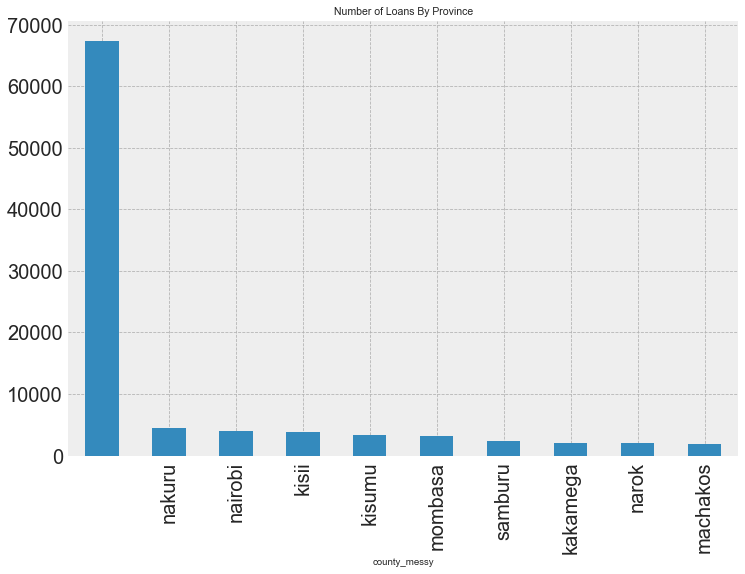

In [550]:
df[(df['borrower_count'] == 1)].groupby('county_messy')['loan_amount'].count().nlargest(10).plot(kind="bar",  fontsize=20,figsize=(12,8),title='Number of Loans By Province')
plt.xticks(rotation=90)

Wow, in the cell below we can see that by playing the fields off against each other we have really reduced the number of nulls for our capital field! Now there are less missing province capitals than counties. We can continue to play the different keys against each other until we get maximum coverage.

### Capital

In [559]:
mydict = dict(zip(lookup_tags.county, lookup_tags.capital))
df['capital']= df['county'].map(mydict)
print ("\nMissing values for province capital:")
len(df[df['capital_messy']==''])
df['capital']=np.where(df['capital_messy']=='',  df['capital'],df['capital_messy'])
print ("\nMissing values for province capital:")
len(df[df['capital'].isnull()])


Missing values for province capital:


69332


Missing values for province capital:


25396

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

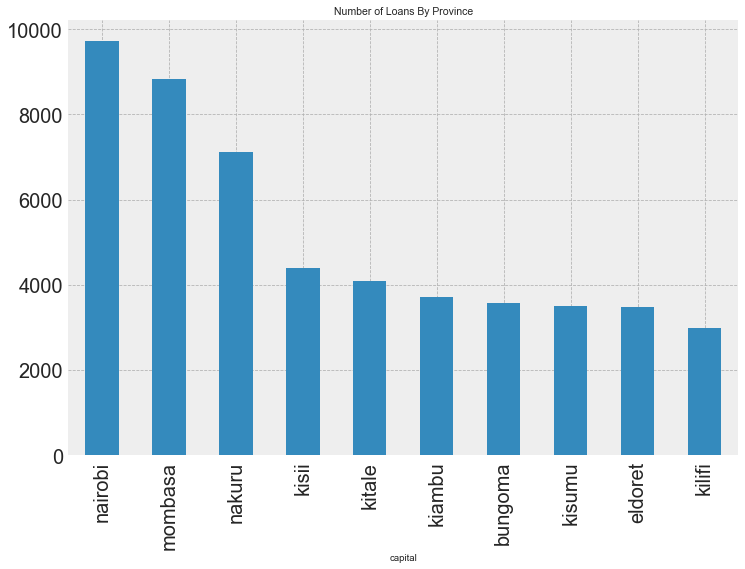

In [560]:
df[(df['borrower_count'] == 1)].groupby('capital')['loan_amount'].count().nlargest(10).plot(kind="bar",  fontsize=20,figsize=(12,8),title='Number of Loans By Province')
plt.xticks(rotation=90)

### Province

In [561]:
mydict = dict(zip(lookup_tags.capital, lookup_tags.province))
df['province_1']= df['capital'].map(mydict)
print ("\nMissing values for province:")
len(df[df['province_messy']==''])
df['province']=np.where(df['province_messy']=='', df['province_1'],df['province_messy'])
print ("\nMissing values for province:")
len(df[df['province'].isnull()])


Missing values for province:


113856


Missing values for province:


25395

### County

In [563]:
print("\nMissing values for county:")
len(df[df['county']==''])

df['county']=np.where(df['county']=='', df['county_messy'],df['county'])
print ("\nMissing values for county:")
len(df[df['county']==''])


Missing values for county:


26073


Missing values for county:


24708

Finally, for the missing we cannot reconcile we populate with 'Missing.' 

In [564]:
df['province']=df['province'].fillna('Missing')
df['county']=df['county'].fillna('Missing')
df['capital']=df['capital'].fillna('Missing')

Before we continue, let's save all of our work!

In [565]:
df.to_csv(data_path+'df_module_2.csv')

### Now we can finally look at our location field!

In [625]:
df = pd.read_csv(data_path+'df_module_2.csv', low_memory=False)

In [626]:
len(df)

118199

We finally have clean data for province and county! Now we can start exploring how location drives the loan amount requested! From the chart below, it is clear that most loans are given out in two provinces in Kenya (rift valley and coast). Notice that we do have a lot of missing data. This is unfortunate, but at least most of our observations have an associated location.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

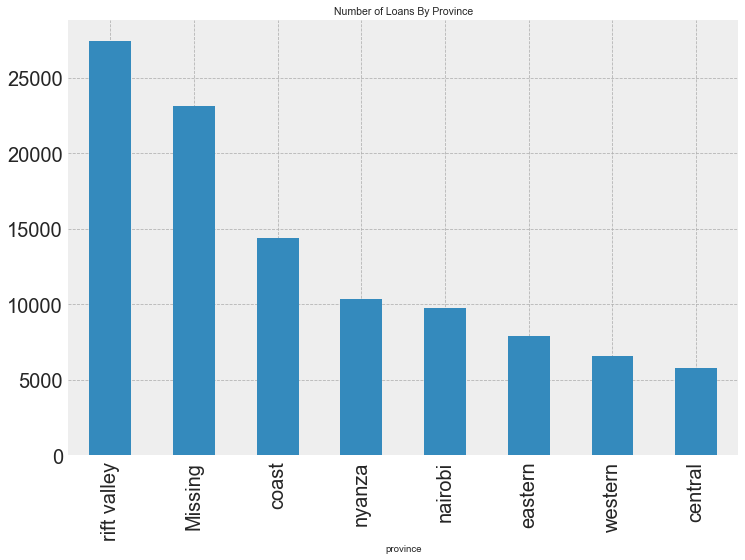

In [627]:
df[(df['borrower_count'] == 1)].groupby('province')['loan_amount'].count().nlargest(10).plot(kind="bar",  fontsize=20,figsize=(12,8),title='Number of Loans By Province')
plt.xticks(rotation=90)

The mean does vary by province, Nairobi has the highest average loan amount out of all the provinces.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

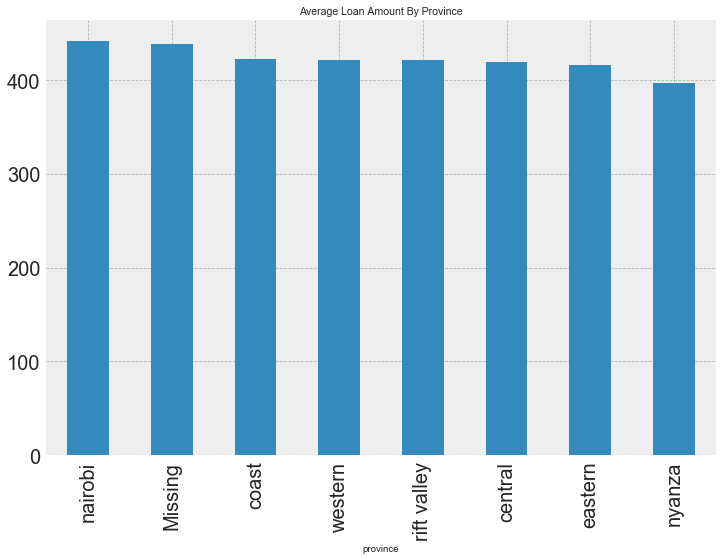

In [628]:
df[(df['borrower_count'] == 1)].groupby('province')['loan_amount'].mean().nlargest(10).plot(kind="bar",  fontsize=20,figsize=(12,8),title='Average Loan Amount By Province')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

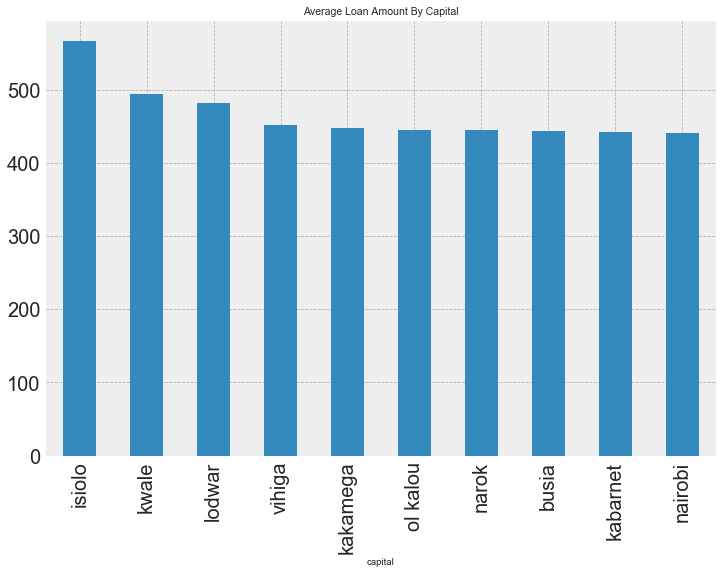

In [629]:
df[(df['borrower_count'] == 1)].groupby('capital')['loan_amount'].mean().nlargest(10).plot(kind="bar",  fontsize=20,figsize=(12,8),title='Average Loan Amount By Capital')
plt.xticks(rotation=90)

Through feature engineering, we have manipulated and created features that we can later include in our models. Next, we will look at features we can create by looking at the partner data. 